# SQL 이용한 EPL 축구 선수 분석
- 출처 : https://www.kaggle.com/datasets/phukaokk/epl-player-2334
- 사용 데이터 : 선수 정보 데이터
- 데이터 수 : 666 rows × 10 columns

In [243]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'AppleGothic'
from bs4 import BeautifulSoup
from datetime import datetime
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import warnings
warnings.filterwarnings("ignore")

### 1. SQL 이용한 데이터 불러오기

In [206]:
# MySQL 데이터베이스 연결
db_config = {
    'host': 'localhost',
    'user': 'root',
    'database': 'developer',
    'port': 3306,
    'charset': 'utf8mb4',
}

# MySQL 데이터베이스 연결
conn = pymysql.connect(**db_config)
cursor = conn.cursor()

# player 테이블의 모든 데이터 삭제
delete_query = "DELETE FROM player;"
cursor.execute(delete_query)
conn.commit()

# SQL 파일 읽기 및 실행
with open('EPL_player_23-24.sql', 'r', encoding='utf-8') as sql_file:
    sql_script = sql_file.read()

queries = sql_script.split(';')
for query in queries:
    if query.strip():
        modified_query = query.replace("''", "NULL")
        cursor.execute(modified_query)

# 변경사항 저장
conn.commit()

# SELECT 쿼리 실행
query = "SELECT * FROM player;"
cursor.execute(query)

# 결과 가져오기
result = cursor.fetchall()

# 결과를 데이터프레임으로 변환
players = pd.read_sql_query(query, conn)

# 연결 닫기
cursor.close()
conn.close()

In [207]:
players

,id,firstName,middleName,lastName,shirtNo,birthDate,position,isBanned,isInjured,teamID
0,17317,Aaron,None,Ramsdale,1.0,1998-05-14,Goalkeeper,None,None,1
1,17318,Karl,None,Hein,31.0,2002-04-13,Goalkeeper,None,None,1
2,17319,David,None,Raya,22.0,1995-09-15,Goalkeeper,None,None,1
3,17320,Ben,None,White,4.0,1997-10-08,Defender,None,None,1
4,17321,Gabriel,None,Magalhães,6.0,1997-12-19,Defender,None,None,1
...,...,...,...,...,...,...,...,...,...,...
661,17978,Nathan,None,Fraser,63.0,2005-02-22,Forward,None,None,20
662,17979,Fábio,None,Silva,9.0,2002-07-19,Forward,None,None,20
663,17980,Matheus,None,Cunha,12.0,1999-05-27,Forward,None,None,20
664,17981,Emilio,None,Ballard-Matthews,78.0,2007-11-30,Forward,None,None,20


### 2. 데이터 확인

In [208]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          666 non-null    int64  
 1   firstName   648 non-null    object 
 2   middleName  0 non-null      object 
 3   lastName    666 non-null    object 
 4   shirtNo     665 non-null    float64
 5   birthDate   643 non-null    object 
 6   position    666 non-null    object 
 7   isBanned    0 non-null      object 
 8   isInjured   0 non-null      object 
 9   teamID      666 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 52.2+ KB


In [209]:
players.isna().sum()

id              0
firstName      18
middleName    666
lastName        0
shirtNo         1
birthDate      23
position        0
isBanned      666
isInjured     666
teamID          0
dtype: int64

#### 2-1. 결측값 많은 컬럼 삭제

In [210]:
# 삭제할 컬럼 - middleName, isBanned, isInjured
players.drop(['middleName', 'isBanned', 'isInjured'], axis = 1, inplace=True)

#### 2-2. 중복 데이터 삭제

In [211]:
players[players.duplicated(subset=players.columns.difference(['id']), keep='first')]

,id,firstName,lastName,shirtNo,birthDate,position,teamID
123,17440,Kevin,Schade,9.0,2001-11-27,Midfielder,4
575,17892,Pedro,Porro,23.0,1999-09-13,Defender,18
592,17909,Dejan,Kulusevski,21.0,2000-04-25,Midfielder,18
653,17970,Boubacar,Traoré,6.0,2001-08-20,Midfielder,20
663,17980,Matheus,Cunha,12.0,1999-05-27,Forward,20


In [212]:
players.drop_duplicates(subset=players.columns.difference(['id']), keep='first', inplace=True)

In [213]:
players = players.reset_index(drop=True)

#### 2-3. id 인덱스 값으로 변경

In [214]:
# id 값을 인덱스 값으로 대체
players['id'] = players.index

#### 2-4. teamID 팀명으로 변경

In [215]:
# 팀ID를 팀명으로 변경
team_mapping = {
    1: '아스널 FC',
    2: '아스톤 빌라 FC',
    3: 'AFC 본머스',
    4: '브렌트포드 FC',
    5: '브라이튼 앤 호브 알비온 FC',
    6: '번리 FC',
    7: '첼시 FC',
    8: '크리스탈 팰리스 FC',
    9: '에버턴 FC',
    10: '풀럼 FC',
    11: '리버풀 FC',
    12: '루턴 타운 FC',
    13: '맨체스터 시티 FC',
    14: '맨체스터 유나이티드 FC',
    15: '뉴캐슬 유나이티드 FC',
    16: '노팅엄 포레스트 FC',
    17: '셰필드 유나이티드 FC',
    18: '토트넘 홋스퍼 FC',
    19: '웨스트햄 유나이티드 FC',
    20: '울버햄튼 원더러스 FC'
}

players['teamID'] = players['teamID'].map(team_mapping)

# 컬럼명 변경
players.rename(columns={'teamID': 'teamName'}, inplace=True)

In [216]:
players[players['teamName'] == '토트넘 홋스퍼 FC']

,id,firstName,lastName,shirtNo,birthDate,position,teamName
559,559,Hugo,Lloris,1.0,1986-12-26,Goalkeeper,토트넘 홋스퍼 FC
560,560,Fraser,Forster,20.0,1988-03-17,Goalkeeper,토트넘 홋스퍼 FC
561,561,Brandon,Austin,40.0,1999-01-08,Goalkeeper,토트넘 홋스퍼 FC
562,562,Alfie,Whiteman,41.0,1998-10-02,Goalkeeper,토트넘 홋스퍼 FC
563,563,Guglielmo,Vicario,13.0,1996-10-07,Goalkeeper,토트넘 홋스퍼 FC
564,564,Charlie,Sayers,3.0,2004-03-29,Defender,토트넘 홋스퍼 FC
565,565,Emerson,Royal,12.0,1999-01-14,Defender,토트넘 홋스퍼 FC
566,566,Eric,Dier,15.0,1994-01-15,Defender,토트넘 홋스퍼 FC
567,567,Cristian,Romero,17.0,1998-04-27,Defender,토트넘 홋스퍼 FC
568,568,Pedro,Porro,23.0,1999-09-13,Defender,토트넘 홋스퍼 FC


Lucas Moura 떠났는데..ㅠ

#### 2-5. 결측값 채우기

In [217]:
players.isna().sum()

id            0
firstName    18
lastName      0
shirtNo       1
birthDate    23
position      0
teamName      0
dtype: int64

In [218]:
# 이름 결측값 확인 - 그대로 진행
players[players['firstName'].isnull()]

,id,firstName,lastName,shirtNo,birthDate,position,teamName
16,16,None,Jorginho,20.0,1991-12-20,Midfielder,아스널 FC
67,67,None,Neto,1.0,1989-07-19,Goalkeeper,AFC 본머스
103,103,None,Zanka,13.0,1990-04-23,Defender,브렌트포드 FC
171,171,None,Vitinho,22.0,1999-07-23,Defender,번리 FC
300,300,None,Beto,14.0,1998-01-31,Forward,에버턴 FC
325,325,None,Willian,20.0,1988-08-09,Forward,풀럼 FC
332,332,None,Adrián,13.0,1987-01-03,Goalkeeper,리버풀 FC
356,356,None,Arthur,29.0,1996-08-12,Midfielder,리버풀 FC
401,401,None,Ederson,31.0,1993-08-17,Goalkeeper,맨체스터 시티 FC
413,413,None,Rodri,16.0,1996-06-22,Midfielder,맨체스터 시티 FC


In [219]:
# 셔츠번호 결측값 1개 확인
players[players['shirtNo'].isnull()]

,id,firstName,lastName,shirtNo,birthDate,position,teamName
129,129,Joel,Valencia,NaN,1994-11-16,Forward,브렌트포드 FC


In [220]:
# 셔츠번호 결측값 채우기 - 프리미어리그 홈페이지 참고
players.loc[players[players['id'] == 129].index, 'shirtNo'] = 16

In [221]:
# 생년월일 결측값 23개 확인
players[players['birthDate'].isnull()]

,id,firstName,lastName,shirtNo,birthDate,position,teamName
144,144,Adam,Lallana,14.0,None,Midfielder,브라이튼 앤 호브 알비온 FC
148,148,Facundo,Buonanotte,40.0,None,Midfielder,브라이튼 앤 호브 알비온 FC
162,162,Mark,O’Mahony,55.0,None,Forward,브라이튼 앤 호브 알비온 FC
164,164,Arijanet,Muric,49.0,None,Goalkeeper,번리 FC
202,202,Djordje,Petrovic,28.0,None,Goalkeeper,첼시 FC
224,224,Moisés,Caicedo,25.0,None,Midfielder,첼시 FC
236,236,Alex,Matos,52.0,None,Forward,첼시 FC
241,241,Joel,Ward,2.0,None,Defender,크리스탈 팰리스 FC
248,248,Nathan,Ferguson,36.0,None,Defender,크리스탈 팰리스 FC
251,251,Luka,Milivojevic,4.0,None,Midfielder,크리스탈 팰리스 FC


In [222]:
# 생년월일 결측값 대체 - 출처: 프리미어 리그 홈페이지
replace_dict = {
    144: '1988-05-10',
    148: '2004-12-23',
    162: '2005-01-14',
    164: '1998-11-07',
    202: '1999-10-08',
    224: '2001-11-02',
    236: '2004-10-03',
    241: '1989-10-29',
    248: '2000-10-06',
    251: '1991-04-07',
    257: '2002-03-29',
    260: '2002-10-05',
    261: '2004-02-18',
    262: '2005-05-06',
    264: '1991-09-11',
    265: '1997-06-28',
    267: '2004-11-25',
    604: '2000-06-08',
    605: '2000-01-24',
    607: '1994-10-27',
    608: '1992-08-22',
    641: '2003-11-04',
    653: '1996-01-26'
}

for id, birth_date in replace_dict.items():
    players.loc[players['id'] == id, 'birthDate'] = birth_date

In [223]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         661 non-null    int64  
 1   firstName  643 non-null    object 
 2   lastName   661 non-null    object 
 3   shirtNo    661 non-null    float64
 4   birthDate  661 non-null    object 
 5   position   661 non-null    object 
 6   teamName   661 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 36.3+ KB


### 3. 데이터 분석

#### 3-1. 각 팀별 포지션 비중 확인

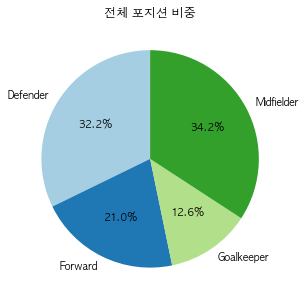

In [268]:
# 전체 포지션 비중
plt.figure(figsize=(5, 5))
colors = plt.cm.Paired(range(len(players['position'].unique())))
players.groupby('position').size().plot.pie(autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('전체 포지션 비중')
plt.show()

미드필더 -> 수비수 -> 공격수 -> 골키퍼 순

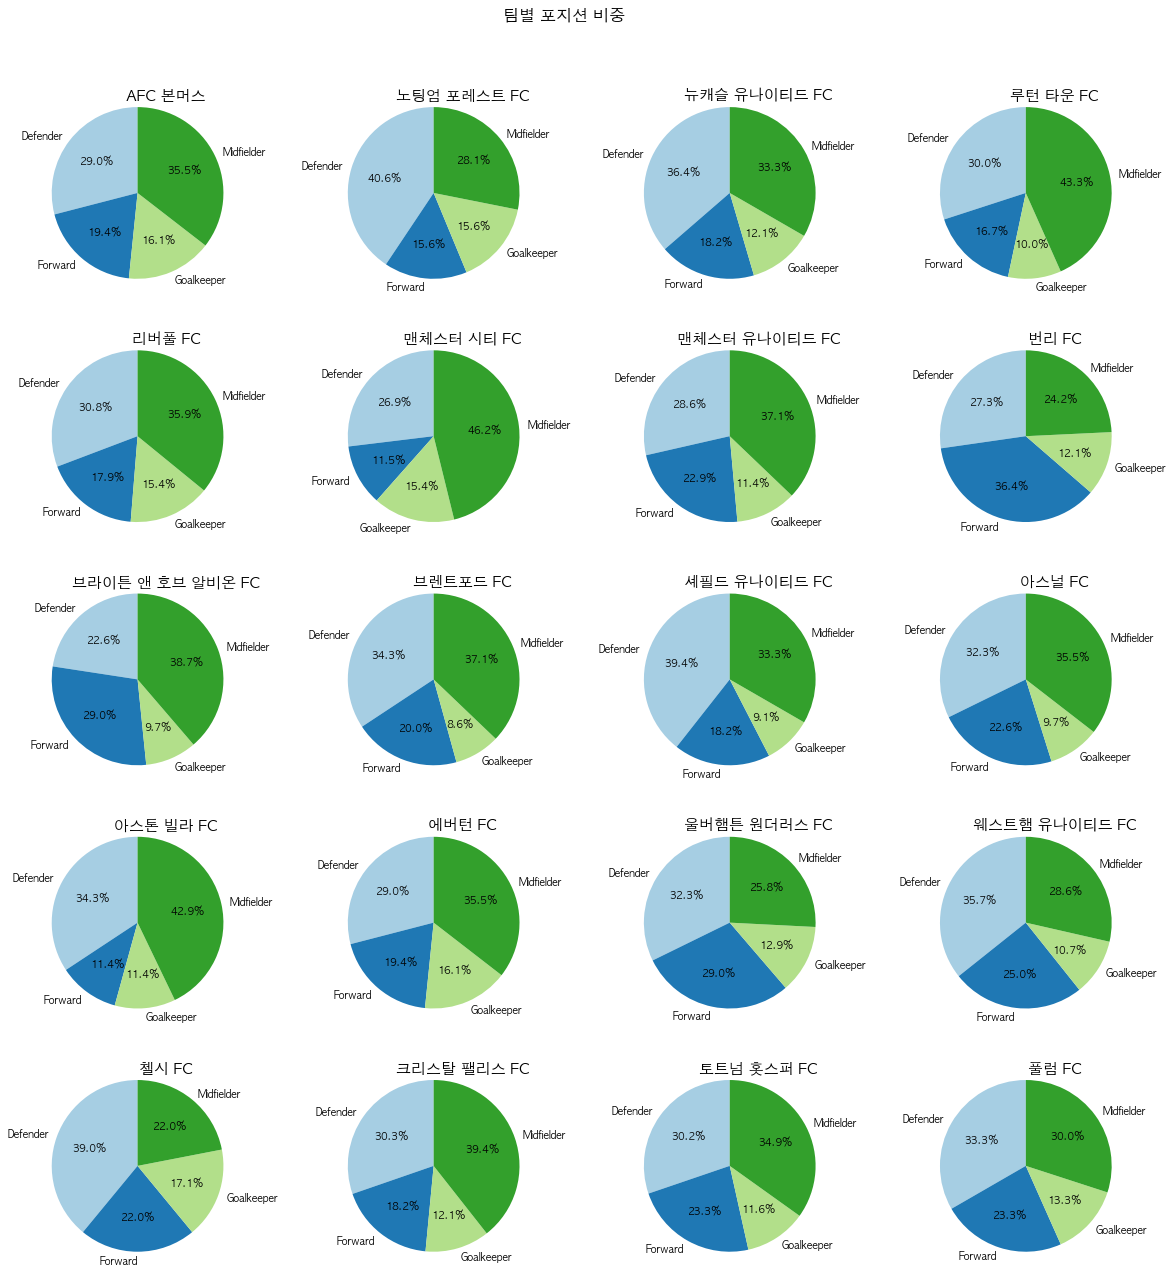

In [162]:
# 각 팀별로 position 비중 확인
team_position_counts = players.groupby(['teamName', 'position']).size().unstack(fill_value=0)

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

# 레이아웃 조정
plt.subplots_adjust(top=0.9, hspace=0.7, wspace=0.3)

# 팀별 파이차트
for (team, row), ax in zip(team_position_counts.iterrows(), axes.flatten()):
    row.plot.pie(ax=ax, autopct='%1.1f%%', colors=plt.cm.Paired(range(len(players['position'].unique()))),
                 startangle=90, radius=1.5) 
    ax.set_ylabel('')
    team_name_x = 0.5
    team_name_y = 1.7
    ax.text(team_name_x, team_name_y, team, ha='center', va='center', fontsize=15)

plt.suptitle('팀별 포지션 비중', fontsize=16, y=0.98)

plt.show()


#### 3-2. 웹 크롤링 이용해 구단별 성적 추출

In [273]:
# ChromeDriver를 자동으로 다운로드하고 사용
driver = webdriver.Chrome(ChromeDriverManager().install())

url = 'https://sports.news.naver.com/wfootball/record/index?category=epl&year=2023&tab=team'
driver.get(url)

print(datetime.today().strftime("%Y년 %m월 %d일의 EPL순위\n"))

soup = BeautifulSoup(driver.page_source, 'html.parser')
teams = soup.select("#wfootballTeamRecordBody > table > tbody > tr")

# 데이터프레임을 만들기 위한 빈 리스트
data = []

for team in teams:
    team_ranking = team.select_one('td.num > div > strong')
    team_name = team.select_one('td.align_l > div > span.name')
    team_point = team.select_one('td.selected > div > span')

    # 데이터를 리스트에 추가
    data.append({
        "rank": team_ranking.text.strip(),
        "teamName": team_name.text.strip(),
        "score": team_point.text.strip(),
    })

# 리스트를 데이터프레임으로 변환
score = pd.DataFrame(data)
print(score)

# 브라우저 닫기
driver.quit()

2023년 12월 11일의 EPL순위

   rank          teamName score
0     1            리버풀 FC    37
1     2            아스널 FC    36
2     3         아스톤 빌라 FC    35
3     4        맨체스터 시티 FC    33
4     5        토트넘 홋스퍼 FC    30
5     6     맨체스터 유나이티드 FC    27
6     7      뉴캐슬 유나이티드 FC    26
7     8  브라이튼 앤 호브 알비온 FC    26
8     9     웨스트햄 유나이티드 FC    24
9    10             풀럼 FC    21
10   11          브렌트포드 FC    19
11   12             첼시 FC    19
12   13      울버햄튼 원더러스 FC    19
13   14           AFC 본머스    19
14   15       크리스탈 팰리스 FC    16
15   16       노팅엄 포레스트 FC    14
16   17            에버턴 FC    13
17   18          루턴 타운 FC     9
18   19             번리 FC     8
19   20      셰필드 유나이티드 FC     8


In [274]:
score

,rank,teamName,score
0,1,리버풀 FC,37
1,2,아스널 FC,36
2,3,아스톤 빌라 FC,35
3,4,맨체스터 시티 FC,33
4,5,토트넘 홋스퍼 FC,30
5,6,맨체스터 유나이티드 FC,27
6,7,뉴캐슬 유나이티드 FC,26
7,8,브라이튼 앤 호브 알비온 FC,26
8,9,웨스트햄 유나이티드 FC,24
9,10,풀럼 FC,21


#### 3-3. 데이터 프레임 합치기

In [275]:
players_df = pd.merge(players, score, on='teamName')

In [276]:
players_df

,id,firstName,lastName,shirtNo,birthDate,position,teamName,rank,score
0,0,Aaron,Ramsdale,1.0,1998-05-14,Goalkeeper,아스널 FC,2,36
1,1,Karl,Hein,31.0,2002-04-13,Goalkeeper,아스널 FC,2,36
2,2,David,Raya,22.0,1995-09-15,Goalkeeper,아스널 FC,2,36
3,3,Ben,White,4.0,1997-10-08,Defender,아스널 FC,2,36
4,4,Gabriel,Magalhães,6.0,1997-12-19,Defender,아스널 FC,2,36
...,...,...,...,...,...,...,...,...,...
656,656,Diego,Costa,29.0,1988-10-07,Forward,울버햄튼 원더러스 FC,13,19
657,657,Nathan,Fraser,63.0,2005-02-22,Forward,울버햄튼 원더러스 FC,13,19
658,658,Fábio,Silva,9.0,2002-07-19,Forward,울버햄튼 원더러스 FC,13,19
659,659,Emilio,Ballard-Matthews,78.0,2007-11-30,Forward,울버햄튼 원더러스 FC,13,19


#### 3-4. 어떤 등번호가 가장 많을까?

In [277]:
# 셔츠번호 정수형으로 변경
players_df['shirtNo'] = players_df['shirtNo'].astype(int)

In [278]:
players_df['shirtNo'].value_counts().head(10)

shirtNo
8     23
1     20
7     19
11    19
4     19
19    19
10    19
5     19
9     18
18    18
Name: count, dtype: int64

8번 -> 1번 -> 7번, 11번, 4번, 19번, 10번, 5번 순으로 많이 사용됨

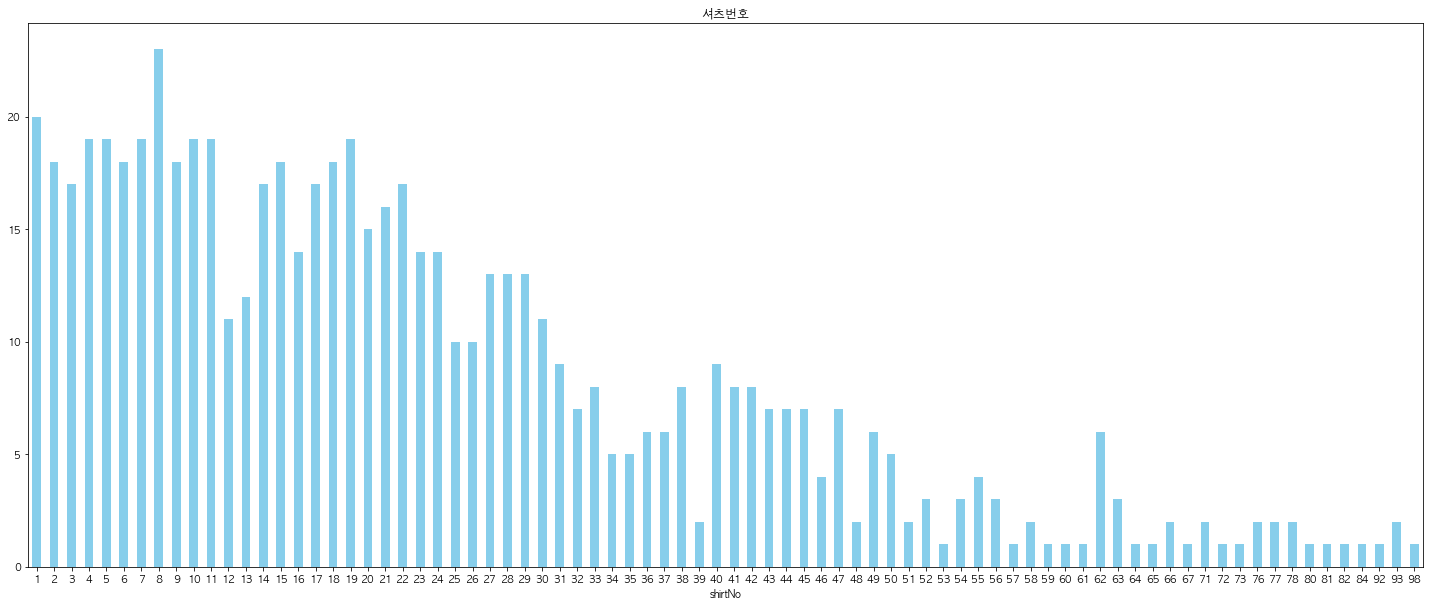

In [238]:
# 히스토그램 
plt.figure(figsize=(25, 10))
players_df['shirtNo'].value_counts().sort_index().plot(kind='bar', color='skyblue')

plt.title('셔츠번호')
plt.xticks(rotation=0)

plt.show()


#### 3-5. 포지션 별 많이 사용하는 등번호는?

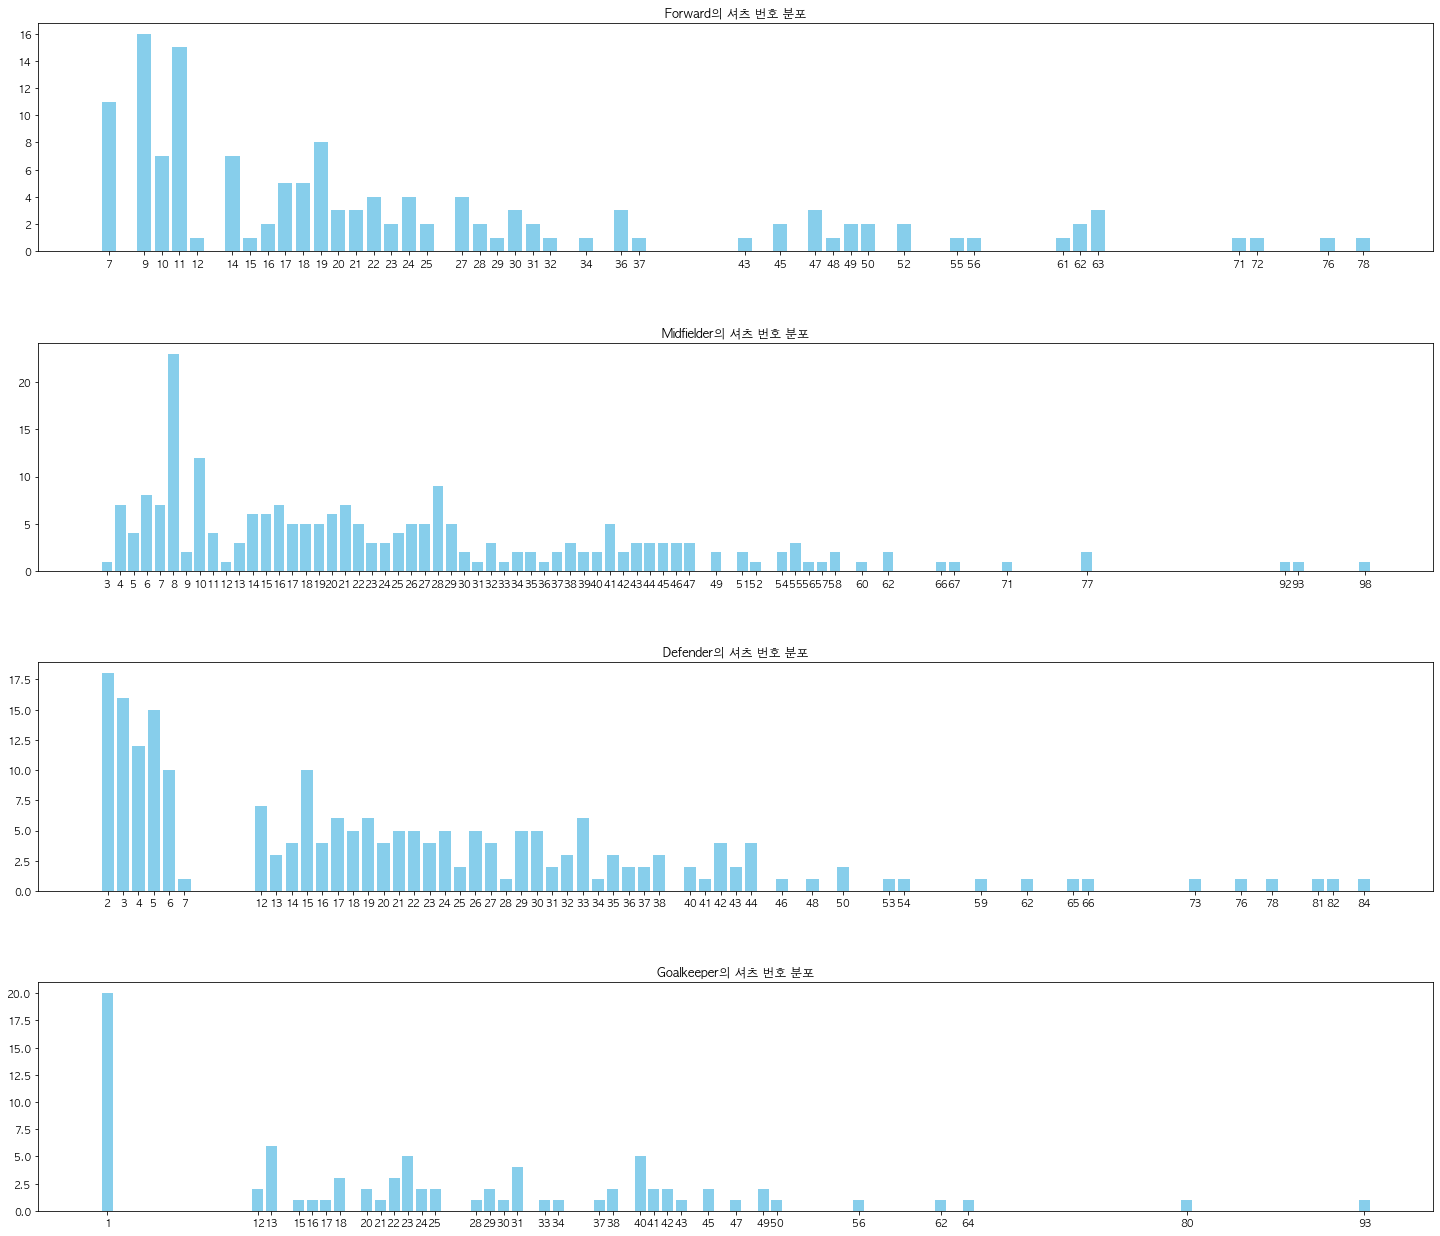

In [271]:
# 각 포지션 별 서브플롯 생성
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(25, 20))
positions = ['Forward', 'Midfielder', 'Defender', 'Goalkeeper']

plt.subplots_adjust(top=0.95, hspace=0.4, wspace=0.3)

# 히스토그램
for position, ax in zip(positions, axes.flatten()):
    subset = players_df[players_df['position'] == position]
    ax.bar(subset['shirtNo'].value_counts().index, subset['shirtNo'].value_counts(), color='skyblue')
    ax.set_title(f'{position}의 셔츠 번호 분포')
    ax.set_xticks(subset['shirtNo'].unique())

plt.show()

대부분 앞번호에 분포되어 있는 편  
공격수 - 7, 9, 11, 19 등  
미드필더 - 다른 번호들에 비해 8번이 독보적  
수비수 - 2, 3, 4, 5, 6 등 앞자리 수에 많이 분포되어 있음  
골키퍼 - 골키퍼는 대부분 1번 부여받음  

#### 3-6. 각 포지션별 나이 분포 확인

In [285]:
# 'birthDate' 컬럼을 datetime 형식으로 변경
players_df['birthDate'] = pd.to_datetime(players_df['birthDate'])

# 현재 날짜 구하기
current_date = datetime.now()

# 'age' 컬럼에 현재 나이 계산하여 삽입
players_df['age'] = (current_date - players_df['birthDate']).dt.days // 365

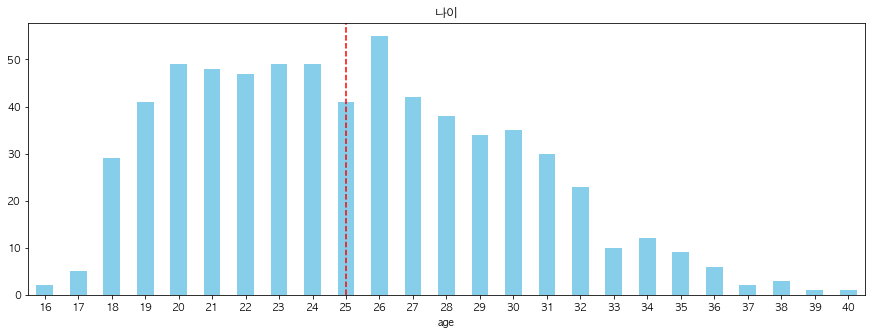

In [307]:
# 전체 나이 분포 확인
plt.figure(figsize=(15, 5))
counts = players_df['age'].value_counts().sort_index()
counts.plot(kind='bar', color='skyblue')

plt.title('나이')
plt.xticks(rotation=0)

# 그래프에 중앙값 표시
median_age_all = players_df['age'].median()
x_coord_all = counts.index.get_loc(median_age_all)
plt.axvline(x=x_coord_all, color='red', linestyle='--')

plt.show()

나이 중앙값은 25  
40대가 있다고..? - 골키퍼였다..!

In [304]:
players_df[players_df['age'] == 40]

,id,firstName,lastName,shirtNo,birthDate,position,teamName,rank,score,age
272,272,Andy,Lonergan,31,1983-10-19,Goalkeeper,에버턴 FC,17,13,40


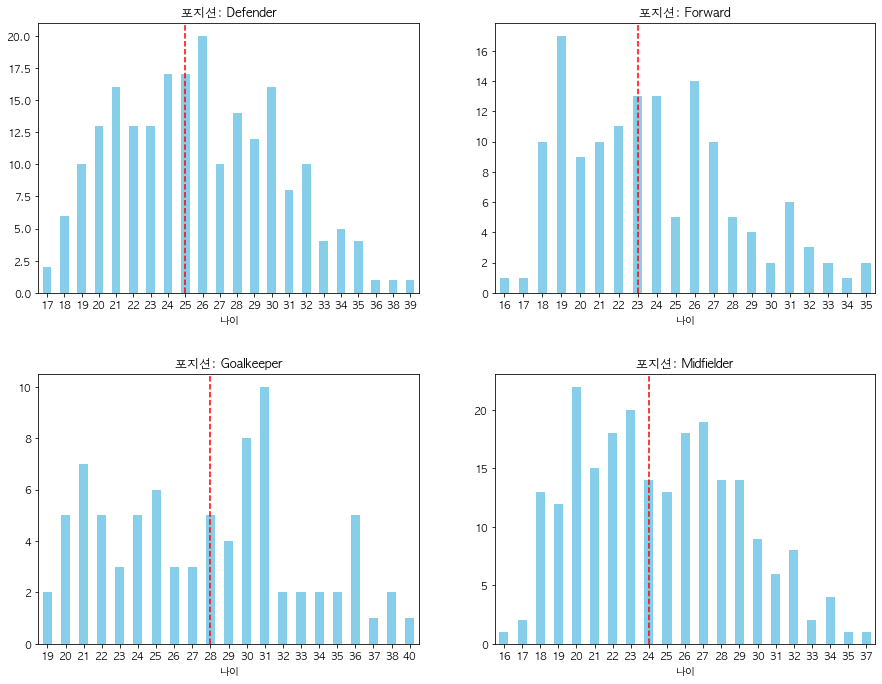

In [305]:
# 각 포지션에 대한 subplot을 생성
fig, axes = plt.subplots(nrows=len(players_df['position'].unique()) // 2, ncols=2, figsize=(15, 15))
plt.subplots_adjust(top=0.7, hspace=0.3)

# 각 포지션별로 그래프 생성
for (position, group), ax in zip(players_df.groupby('position'), axes.flatten()):
    counts = group['age'].value_counts().sort_index()
    counts.plot(kind='bar', color='skyblue', ax=ax)
    ax.set_title(f'포지션: {position}')
    ax.set_xlabel('나이')
    ax.set_xticklabels(counts.index, rotation=0)
    
    # 중앙값 그래프에 표시
    median_age = group['age'].median()
    x_coord = counts.index.get_loc(median_age)
    ax.axvline(x=x_coord, color='red', linestyle='--')

plt.show()


공격수 -> 미드필더 -> 수비수 -> 골키퍼 순으로 연령대 상승

#### 3-6. 각 팀별 나이 분포 확인

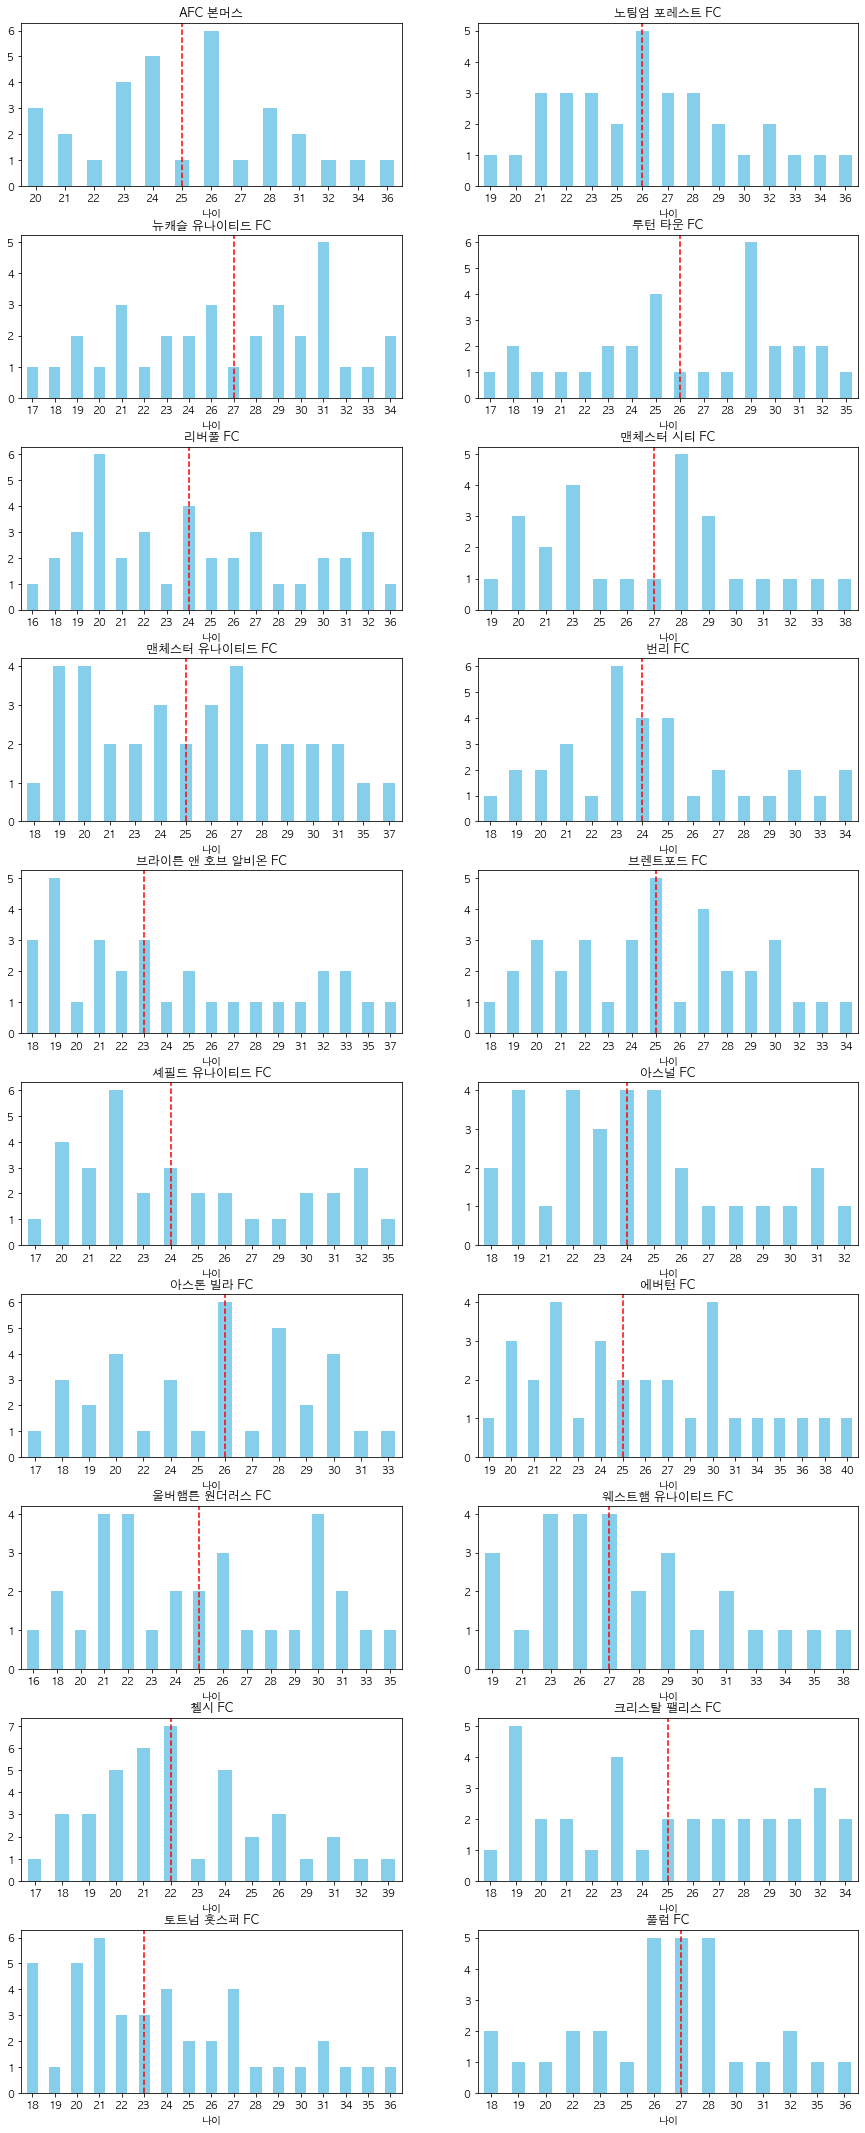

In [313]:
# 각 구단에 대한 subplot을 생성
fig, axes = plt.subplots(nrows=len(players_df['teamName'].unique()) // 2, ncols=2, figsize=(15, 50))
plt.subplots_adjust(top=0.7, hspace=0.3)

# 각 구단별로 그래프 생성
for (teamName, group), ax in zip(players_df.groupby('teamName'), axes.flatten()):
    counts = group['age'].value_counts().sort_index()
    counts.plot(kind='bar', color='skyblue', ax=ax)
    ax.set_title(f'{teamName}')
    ax.set_xlabel('나이')
    ax.set_xticklabels(counts.index, rotation=0)
    
    # 중앙값 그래프에 표시
    median_age = group['age'].median()
    median_age_int = int(median_age)
    x_coord = counts.index.get_loc(median_age_int)
    ax.axvline(x=x_coord, color='red', linestyle='--')

plt.show()

맨시티, 뉴캐슬, 웨스트햄, 풀럼이 연장자 클럽  
첼시, 토트넘이 어린이(?)클럽

In [314]:
# 구단별 나이 중앙값
players_df.groupby('teamName')['age'].median()

teamName
AFC 본머스             25.0
노팅엄 포레스트 FC         26.0
뉴캐슬 유나이티드 FC        27.0
루턴 타운 FC            26.5
리버풀 FC              24.0
맨체스터 시티 FC          27.5
맨체스터 유나이티드 FC       25.0
번리 FC               24.0
브라이튼 앤 호브 알비온 FC    23.0
브렌트포드 FC            25.0
셰필드 유나이티드 FC        24.0
아스널 FC              24.0
아스톤 빌라 FC           26.0
에버턴 FC              25.0
울버햄튼 원더러스 FC        25.0
웨스트햄 유나이티드 FC       27.0
첼시 FC               22.0
크리스탈 팰리스 FC         25.0
토트넘 홋스퍼 FC          23.0
풀럼 FC               27.0
Name: age, dtype: float64

In [324]:
# 구단별 연령 중앙값 삽입
score = score.merge(players_df.groupby('teamName')['age'].median().reset_index(), on='teamName', how='left')

#### 3-7. 구단별 나이 중앙값과 구단 성적과의 상관관계

In [328]:
score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rank      20 non-null     object 
 1   teamName  20 non-null     object 
 2   score     20 non-null     object 
 3   age       20 non-null     float64
dtypes: float64(1), object(3)
memory usage: 768.0+ bytes


In [329]:
# 데이터 타입 변경
score['rank'] = score['rank'].astype(int)
score['score'] = score['score'].astype(int)

In [330]:
# 연령과 구단 성적의 상관관계
score['score'].corr(score['age'])

0.026614277828096077

거의 관련 없음ㅠ

#### 3-8. 포지션 비중과 구단 성적과의 상관관계

In [334]:
# 구단별 포지션 비중
players_df.groupby(['teamName', 'position']).size().unstack()

position,Defender,Forward,Goalkeeper,Midfielder
teamName,,,,
AFC 본머스,9,6,5,11
노팅엄 포레스트 FC,13,5,5,9
뉴캐슬 유나이티드 FC,12,6,4,11
루턴 타운 FC,9,5,3,13
리버풀 FC,12,7,6,14
맨체스터 시티 FC,7,3,4,12
맨체스터 유나이티드 FC,10,8,4,13
번리 FC,9,12,4,8
브라이튼 앤 호브 알비온 FC,7,9,3,12


In [338]:
# 구단별 포지션 분포 데이터 합치기
score = players_df.groupby(['teamName', 'position']).size().unstack().merge(score, on='teamName', how='left')

In [340]:
# 수비수 포지션 비중과 구단 성적과의 상관관계
score['score'].corr(score['Defender'])

-0.019011640224741746

In [341]:
# 공격수 포지션 비중과 구단 성적과의 상관관계
score['score'].corr(score['Forward'])

-0.15672597925133425

In [342]:
# 골키퍼 포지션 비중과 구단 성적과의 상관관계
score['score'].corr(score['Goalkeeper'])

0.10034967373051983

In [343]:
# 미드필더 포지션 비중과 구단 성적과의 상관관계
score['score'].corr(score['Midfielder'])

0.45489714708942575

!!! 미드필더 중심의 높은 포지션 비중을 둔 구단은 높은 성적을 가진다는 중간 정도의 상관관계가 있다
